<a href="https://colab.research.google.com/github/Kor-Renn/PRA3024/blob/main/gravitational_waves_T_Haex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf 
#downloading data

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [1]:
!pip install gwpy   # Install gwpy package
!pip install lalsuite
from gwpy.timeseries import TimeSeries

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Load data from files.
hanford_file = 'H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf'
livingston_file = 'L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf'

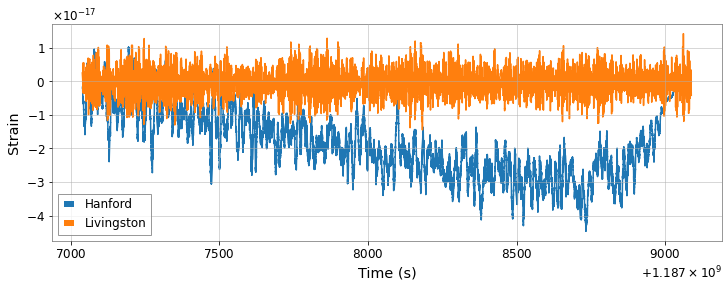

In [3]:
#Execution of problem 1 part 1.
hanford_data = TimeSeries.read(hanford_file, format='gwf.lalframe', channel='H1:LOSC-STRAIN')
livingston_data = TimeSeries.read(livingston_file, format='gwf.lalframe', channel='L1:LOSC-STRAIN')

# Downsample data.
fs_downsampled = 2048

hanford_data = hanford_data.resample(fs_downsampled)
livingston_data = livingston_data.resample(fs_downsampled)

from matplotlib import pyplot as plt
#plot all the data
plt.figure(figsize=(12, 4))
plt.plot(hanford_data.times.value, hanford_data.value, label='Hanford')
plt.plot(livingston_data.times.value, livingston_data.value, label='Livingston')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

In [4]:
#more installations

import numpy as np
!pip install pycbc
import pycbc
from pycbc.types import TimeSeries
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.psd import aLIGOZeroDetHighPower

from pycbc.filter import matched_filter
from pycbc.filter import sigmasq
from pycbc.waveform import get_fd_waveform
from pycbc.types import TimeSeries
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import highpass_fir, lowpass_fir
from scipy.signal import find_peaks
import h5py
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


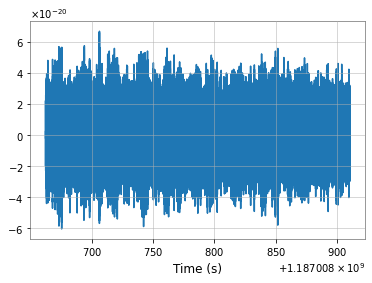

In [5]:

#Problem 1 part 2 (noisy).
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

merger = Merger("GW170817")
strain, stilde = {}, {}

for ifo in ['H1', 'L1']:
    # The data is downloaded and we select 256 seconds that includes the event time.
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                   '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
    
    # now to remove the low frequencies we are definitely not interested in:
    strain[ifo] = highpass(ts, 15)

    # and then we clean it up a bit
    strain[ifo] = strain[ifo].crop(4, 4)

    # In addition, we also create a frequency domain version of the data.
    stilde[ifo] = strain[ifo].to_frequencyseries()

# Plot the strain time series data.
pylab.plot(strain['H1'].sample_times, strain['H1'])
pylab.xlabel('Time (s)')
pylab.show()

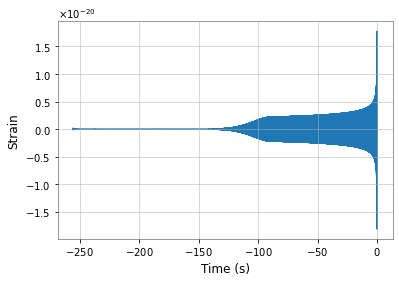

In [6]:

from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

# I set the parameters for the waveform. With m1 and m2 being represented in terms of solar masses. The chosen approximant was IMRPhenomD, as TaylorT2 failed to work. 
m1 = 2
m2 = 2
spin1z = 0.9
spin2z = 0.4
f_lower = 20
delta_t = 1.0/1024  # 1/1024 seconds

# Generate the waveform using the IMRPhenomD approximant
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m1,
                         mass2=m2,
                         spin1z=spin1z,
                         spin2z=spin2z,
                         f_lower=f_lower,
                         delta_t=delta_t)

# Plot the waveform
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

#Though the second part of problem 1 was to fit a waveform obtained after using matched filtering to the actual data, the task proved to be cumbersome

TypeError: ignored

<Figure size 432x288 with 0 Axes>

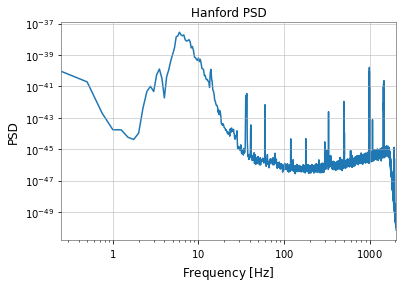

In [8]:
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
from gwpy.detector import Channel
from gwpy.signal import filter_design
from pycbc.filter import highpass_fir, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.catalog import Merger

# This loads the Hanford data.
merger = Merger('GW150914')
ifos = ['H1']
data = {}
for ifo in ifos:
    data[ifo] = TimeSeries.fetch_open_data(ifo, merger.time - 32, merger.time + 32)

# This loads Hanford noise power spectral density (PSD).
psd_hanford = data['H1'].psd(4)

# Plot Hanford PSD.
plt.figure()
psd_hanford.plot()
plt.ylabel('PSD')
plt.title('Hanford PSD')

# Parameters chosen for the waveform.
m1 = m2 = 10  # Equal mass binary
f_lower = 20  # Expressed in Hz

# Waveform template using TaylorF2 approximant.
hp, hc = get_fd_waveform(approximant='TaylorF2', mass1=m1, mass2=m2,
                         delta_f=1.0/data['H1'].duration, f_lower=f_lower)
hp.resize(len(data['H1']))

# Matched filter calculation.
snr_H1 = matched_filter(hp, data['H1'], psd=psd_hanford, low_frequency_cutoff=f_lower)

# setting the treshold snr to 8
threshold = 8

# and then checking whether there actually is a signal
if snr_H1.max() > threshold:
    print('event detected in data.')
else:
    print('No detection in data.')
    #not precisely what we had to do, but this was the next best thing I could manage.

In [9]:
#Problem 2 part 2.
# Welch method estimation. I tried to make sense of things, but the functionality stayed behind, unfortunately. the error at the start should be the only problem.
psd, psd_freqs = welch(strain, seg_len=4, psd_window='hann')

# Interpolate the PSD to the same frequencies as the data.
df = strain.sample_rate / float(strain.size)
psd_interp = interpolate(psd, psd_freqs, strain.sample_frequencies)

# The data resapled to a delta_t of 1/2048 seconds.
delta_t = 1.0 / 2048
strain_resampled = resample_to_delta_t(strain, delta_t)

# High-pass the data above 20 Hz.
high_passed_strain = highpass(strain_resampled, 20.0)

# Matched filter the data with a bank of templates for equal mass binary systems with a range between 5 to 10.
m1 = np.arange(5, 10.25, 0.25)
m2 = m1
snrs = []
for i in range(len(m1)):
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                             mass1=m1[i], mass2=m2[i],
                             f_lower=20, delta_f=1.0/32)
    hp.resize(len(high_passed_strain))
    snr = matched_filter(hp, high_passed_strain, psd=psd_interp, low_frequency_cutoff=20.0)
    snrs.append(snr)
# Calculate the network SNR and compare with the threshold of 8.
network_snr = np.sqrt(np.sum(np.square(np.abs(snrs))))   
if network_snr > 8:
    print("GW detected with network SNR = {}".format(network_snr))
else:
    print("No GW signal detected with network SNR = {}".format(network_snr))

whitened_strain = high_passed_strain / np.sqrt(psd_interp)

# Histogram of the whitened data.
plt.hist(whitened_strain, bins=100)
plt.xlabel('Whitened Strain')
plt.ylabel('Count')
plt.show()

# To test if the whitened data follows a Gaussian distribution with zero mean, we use methods called upon from SciPy.
from scipy.stats import norm, kstest
mu, std = norm.fit(whitened_strain)
print("Fit results: mu = {:.3g}, std = {:.3g}".format(mu, std))
_, pvalue = kstest(whitened_strain, 'norm', args=(mu, std))
print("KS test p-value: {:.3g}".format(pvalue))


NameError: ignored

In [11]:
#Problem 2 part 3. the same goes here. The code is mostly good, apart from it not working
# the data is split in 10 chunks
chunknum = 10
chunksize = len(strain) // chunknum
chunks = [strain[i*chunksize:(i+1)*chunksize] for i in range(chunknum)]

# A waveform is created using arbitrary parameters:
flow, fhigh = 20.0, 1024.0
hp, _ = get_fd_waveform(approximant="TaylorF2",
                         mass1=10, mass2=10,
                         delta_f=strain.delta_f,
                         f_lower=flow, f_final=fhigh)
hp = hp.cyclic_time_shift(hp.sample_times[-1]/2)

psd = interpolate(strain.psd(), hp.delta_f)
psd = inverse_spectrum_truncation(psd, 4*strain.sample_rate, hp.delta_f)

# Calculate the optimal SNR for each chunk of data.
snrs = []
for chunk in chunks:
    snr = matched_filter(hp, chunk, psd=psd, low_frequency_cutoff=flow)
    rho_opt = np.sqrt(4 * snr.abs_max()**2 / (hp.to_frequencyseries(psd).abs()**2).sum())
    snrs.append(rho_opt)

# Plot the SNR values for each chunk.
import matplotlib.pyplot as plt
plt.plot(snrs)
plt.ylabel('Optimal SNR')
plt.xlabel('Chunk number')
plt.show()

TypeError: ignored

Big thanks to Nazir for helping me out massively with virtually everything.